In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"swaradapathak","key":"0122cd4f102ccfde6a5847f9872440a2"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d puneet6060/intel-image-classification

 96% 333M/346M [00:02<00:00, 184MB/s]
100% 346M/346M [00:02<00:00, 137MB/s]


In [6]:
! unzip intel-image-classification.zip


Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [7]:
#Importing the neccessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils #dataset loading, model visualization
from tensorflow.keras.utils import model_to_dot #graphical representation of a Keras model as a Graphviz dot graph.
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec

Train

In [9]:
#Reading images
df_train = tf.keras.utils.image_dataset_from_directory(
    "/content/seg_train/seg_train",
    labels='inferred', # labels from directory
    label_mode='int', #Encode labels as int [0,1...,6]
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(150,150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 14034 files belonging to 6 classes.


In [10]:
df_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Testing

In [11]:
df_test = tf.keras.utils.image_dataset_from_directory(
    "/content/seg_test/seg_test",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(150,150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 3000 files belonging to 6 classes.


In [12]:
df_test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
# getting class names of training data
class_names = df_train.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [14]:
# Dictionary comprehension
class_count = {class_name: 0 for class_name in class_names}
# initially assign 0 to each class name
class_count

{'buildings': 0,
 'forest': 0,
 'glacier': 0,
 'mountain': 0,
 'sea': 0,
 'street': 0}

In [16]:
for _, labels in df_train: #_ : placeholder
  for label in labels.numpy(): # converts tensor into numpy and iterating over labels
    class_name = class_names[label]
    class_count[class_name] += 1

In [17]:
for class_name, count in class_count.items():
  print(f"{class_name}: {count}")

buildings: 4382
forest: 4542
glacier: 4808
mountain: 5024
sea: 4548
street: 4764


In [18]:
cls = pd.DataFrame(df_train.class_names).reset_index()
cls.rename(columns={'index': 'label', 0: 'class_name'}, inplace = True)
cls['class_name']=cls["class_name"].str.title()
cls['count']=class_count.values()
cls

,label,class_name,count
0,0,Buildings,4382
1,1,Forest,4542
2,2,Glacier,4808
3,3,Mountain,5024
4,4,Sea,4548
5,5,Street,4764


In [19]:
#converting the dataset to a NumPy iterator which allows iterate over dataset
data_iterator = df_train.as_numpy_iterator()

In [20]:
batch =data_iterator.next() #returns 2 things: batch[0]-> Images and batch[1]-> Labels

In [21]:
for image_batch, labels_batch in df_train:
    print(image_batch.shape) # batch_size, image size, channels(rgb)
    print(labels_batch.shape) # batch size
    break

(32, 150, 150, 3)
(32,)


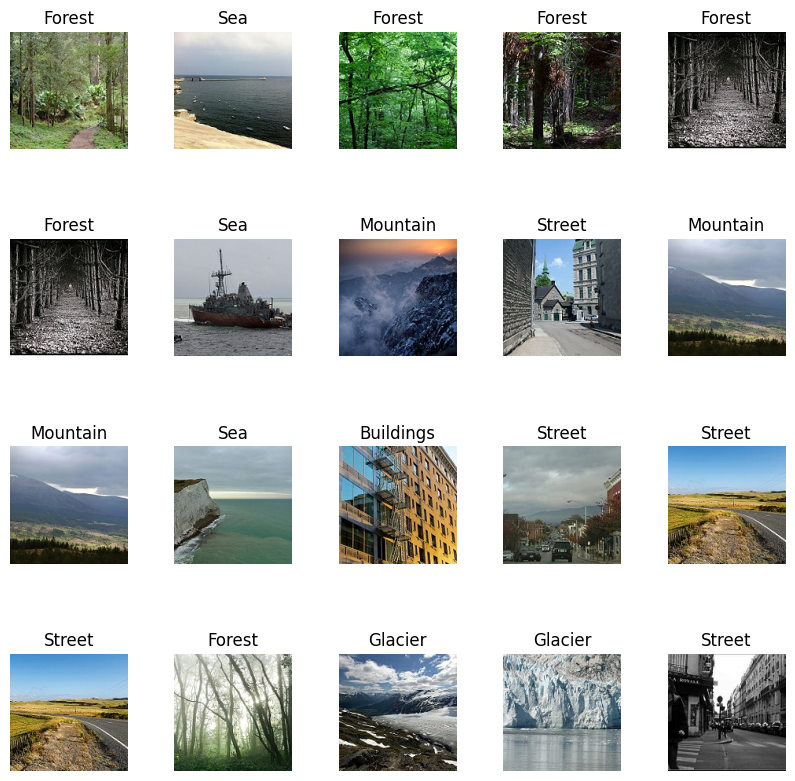

In [22]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(10, 10)) # creating subplot array
for i in range(4):
    for j in range(5):
        index = i * 4 + j
        ax[i, j].imshow(batch[0][index].astype(int)) # print images
        ax[i, j].set_title(cls["class_name"][batch[1][index]]) # print associated titles
        ax[i,j].axis('off') # no axis
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


In [24]:
model = Models.Sequential()

#Convolution
model.add(Layers.Conv2D(200, kernel_size=(5,5),activation='relu',input_shape=(150,150,3)))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Flatten())

#ANN
model.add(Layers.Dense(180,activation='relu'))

#O/P Layer 6 becuase - 6 classes
model.add(Layers.Dense(6,activation='softmax'))

model.compile(optimizer = Optimizer.Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 146, 146, 200)     15200     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 200)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 168200)            0         
                                                                 
 dense_2 (Dense)             (None, 180)               30276180  
                                                                 
 dense_3 (Dense)             (None, 6)                 1086      
                                                                 
Total params: 30292466 (115.56 MB)
Trainable params: 30292466 (115.56 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
Utils.plot_model(model,to_file='model.png',show_shapes=True)


In [25]:
trained = model.fit(df_train, validation_data = df_test,validation_split=0.3,
                    epochs =10)

Epoch 1/10
439/439 [==============================] - 33s 62ms/step - loss: 39.1517 - accuracy: 0.3433 - val_loss: 1.6878 - val_accuracy: 0.3123
Epoch 2/10
439/439 [==============================] - 23s 53ms/step - loss: 1.2890 - accuracy: 0.4833 - val_loss: 1.6660 - val_accuracy: 0.3617
Epoch 3/10
439/439 [==============================] - 23s 52ms/step - loss: 0.9771 - accuracy: 0.6051 - val_loss: 1.7415 - val_accuracy: 0.4367
Epoch 4/10
439/439 [==============================] - 24s 55ms/step - loss: 0.7001 - accuracy: 0.7214 - val_loss: 2.0375 - val_accuracy: 0.4490
Epoch 5/10
439/439 [==============================] - 24s 54ms/step - loss: 0.5387 - accuracy: 0.7877 - val_loss: 2.5273 - val_accuracy: 0.4367
Epoch 6/10
439/439 [==============================] - 25s 56ms/step - loss: 0.4771 - accuracy: 0.8167 - val_loss: 2.9536 - val_accuracy: 0.4383
Epoch 7/10
439/439 [==============================] - 24s 53ms/step - loss: 0.4268 - accuracy: 0.8345 - val_loss: 3.0876 - val_accuracy

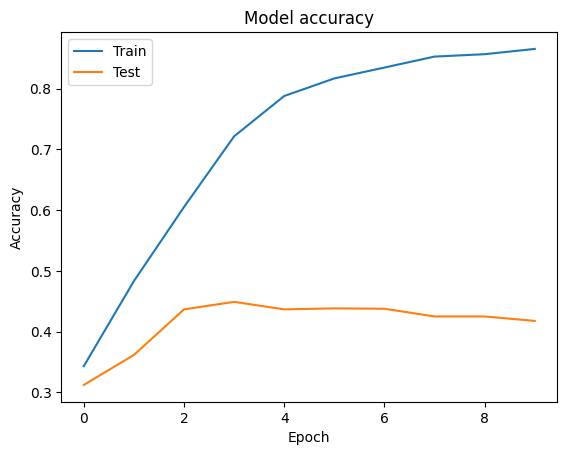

In [26]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

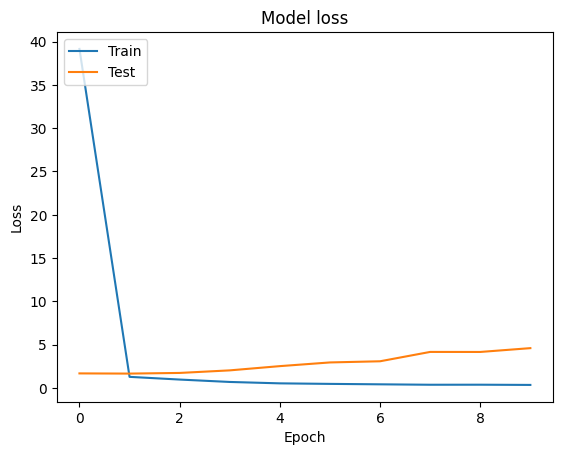

In [27]:
plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [30]:
model2 = Models.Sequential()

#Convolution
model2.add(Layers.Conv2D(200, kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model2.add(Layers.Conv2D(180, kernel_size=(3,3),activation='relu'))
model2.add(Layers.MaxPool2D(3,3))
model2.add(Layers.Flatten())

#ANN
model2.add(Layers.Dense(180,activation='relu'))
model2.add(Layers.Dense(120,activation='relu'))

#O/P Layer 6 becuase - 6 classes
model2.add(Layers.Dense(6,activation='softmax'))

model2.compile(optimizer = Optimizer.Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 200)     5600      
                                                                 
 conv2d_5 (Conv2D)           (None, 146, 146, 180)     324180    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 180)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 414720)            0         
                                                                 
 dense_7 (Dense)             (None, 180)               74649780  
                                                                 
 dense_8 (Dense)             (None, 120)               21720     
                                                      

In [ ]:
trained2 = model2.fit(df_train, validation_data = df_test,validation_split=0.3,
                    epochs =10)

Epoch 1/10
439/439 [==============================] - 142s 321ms/step - loss: 18.5941 - accuracy: 0.3158 - val_loss: 1.3621 - val_accuracy: 0.4063
Epoch 2/10
439/439 [==============================] - 137s 311ms/step - loss: 1.2911 - accuracy: 0.4505 - val_loss: 1.2463 - val_accuracy: 0.4553
Epoch 3/10
439/439 [==============================] - 136s 309ms/step - loss: 0.9687 - accuracy: 0.6067 - val_loss: 1.4121 - val_accuracy: 0.4490
Epoch 4/10
273/439 [=================>............] - ETA: 48s - loss: 0.6894 - accuracy: 0.7212

In [ ]:
plt.plot(trained2.history['accuracy'])
plt.plot(trained2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(trained2.history['loss'])
plt.plot(trained2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model3 = Models.Sequential()

#Convolution
model3.add(Layers.Conv2D(200, kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model3.add(Layers.Conv2D(180, kernel_size=(3,3),activation='relu'))

model3.add(Layers.MaxPool2D(3,3))
model3.add(Layers.Conv2D(160, kernel_size=(3,3),activation='relu'))
model3.add(Layers.Conv2D(140, kernel_size=(3,3),activation='relu'))

model3.add(Layers.MaxPool2D(3,3))
model3.add(Layers.Flatten())

#ANN
model3.add(Layers.Dense(180,activation='relu'))
model3.add(Layers.Dropout(rate=0.5))
model3.add(Layers.Dense(120,activation='relu'))
model3.add(Layers.Dense(60,activation='relu'))

#O/P Layer 6 becuase - 6 classes
model3.add(Layers.Dense(6,activation='softmax'))

model3.compile(optimizer = Optimizer.Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model3.summary()

In [ ]:
trained3 = model3.fit(df_train, validation_data = df_test,validation_split=0.3,
                    epochs =30)

In [ ]:
plt.plot(trained3.history['accuracy'])
plt.plot(trained3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(trained3.history['loss'])
plt.plot(trained3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Function for predicting the image
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(150, 150))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.

    prediction = model.predict(img_processed)

    index = np.argmax(prediction)

    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)

In [ ]:
from tensorflow.keras.preprocessing import image
predict_image(filename, model)
